In [ ]:
# This prevents Git from trying to download the large model
!GIT_LFS_SKIP_SMUDGE=1 git clone https://github.com/amrgaberM/GPT-Implementation
%cd GPT-Implementation


Cloning into 'GPT-Implementation'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 54 (delta 18), reused 41 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 35.33 MiB | 22.51 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/GPT-Implementation


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken
import os
from src.model import GPT
from src.config import cfg



In [ ]:
# 1 Load the model
device='cuda' if torch.cuda.is_available() else 'cpu'
model=GPT().to(device)
modelP=cfg.model_path


In [ ]:
if os.path.exists(modelP):
    state_dict = torch.load(modelP, map_location=device)
    model.load_state_dict(state_dict)
    model.eval() # Disables dropout for clean analysis
    print(f"✅ Model loaded from {modelP}")
else:
    print(f"⚠️ Model file not found at {modelP}. Please check the path.")

✅ Model loaded from models/model_finalV2.pth


In [ ]:
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import entropy

def visualize_depth_scan(model, text, head_idx=0, layers=None, show_stats=True):
    """
    Enhanced depth analysis comparing attention patterns across layers.

    Args:
        model: GPT model with saved attention scores
        text: Input text to analyze
        head_idx: Which attention head to visualize (default: 0)
        layers: List of layers to compare (default: [0, 5, 11] for shallow/mid/deep)
        show_stats: Whether to display attention statistics
    """
    enc = tiktoken.get_encoding("gpt2")
    ids = enc.encode(text)
    x = torch.tensor(ids).unsqueeze(0)
    tokens = [enc.decode([i]) for i in ids]

    # Default: compare first, middle, and last layers
    if layers is None:
        n_layers = len(model.transformer.h)
        layers = [0, n_layers // 2, n_layers - 1]

    # Run model to capture attention scores
    with torch.no_grad():
        model(x)

    # Collect attention matrices
    att_matrices = []
    for layer_num in layers:
        att_tensor = model.transformer.h[layer_num].attn.last_att_scores
        att_matrix = att_tensor[0, head_idx].cpu().numpy()
        att_matrices.append(att_matrix)

    # Create figure with optional stats subplot
    n_plots = len(layers)
    if show_stats:
        fig = plt.figure(figsize=(6 * n_plots + 4, 8))
        gs = GridSpec(2, n_plots + 1, height_ratios=[3, 1], width_ratios=[1] * n_plots + [0.3])
    else:
        fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 8))
        if n_plots == 1:
            axes = [axes]

    # Find global min/max for consistent color scaling
    vmin = min(mat.min() for mat in att_matrices)
    vmax = max(mat.max() for mat in att_matrices)

    # Plot heatmaps
    for i, (layer_num, att_matrix) in enumerate(zip(layers, att_matrices)):
        if show_stats:
            ax = fig.add_subplot(gs[0, i])
        else:
            ax = axes[i]

        # Create heatmap
        im = ax.imshow(att_matrix, cmap="viridis", aspect='auto',
                       vmin=vmin, vmax=vmax, interpolation='nearest')

        # Set ticks with better spacing for long sequences
        n_tokens = len(tokens)
        if n_tokens > 20:
            step = max(1, n_tokens // 10)
            tick_indices = range(0, n_tokens, step)
            ax.set_xticks(tick_indices)
            ax.set_yticks(tick_indices)
            ax.set_xticklabels([tokens[j] for j in tick_indices], rotation=45, ha='right', fontsize=8)
            ax.set_yticklabels([tokens[j] for j in tick_indices], fontsize=8)
        else:
            ax.set_xticks(range(n_tokens))
            ax.set_yticks(range(n_tokens))
            ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
            ax.set_yticklabels(tokens, fontsize=9)

        # Layer-specific titles
        if layer_num == 0:
            layer_type = "Syntax/Grammar"
        elif layer_num == layers[-1]:
            layer_type = "Semantics/Meaning"
        else:
            layer_type = "Intermediate"

        ax.set_title(f"Layer {layer_num}: {layer_type}\n(Head {head_idx})", fontsize=12, fontweight='bold')
        ax.set_xlabel("Key (Attending TO)", fontsize=10)
        if i == 0:
            ax.set_ylabel("Query (Attending FROM)", fontsize=10)

        # Add grid for easier reading
        ax.grid(False)

    # Add shared colorbar
    if show_stats:
        cbar_ax = fig.add_subplot(gs[0, -1])
        fig.colorbar(im, cax=cbar_ax, label='Attention Weight')
    else:
        fig.colorbar(im, ax=axes, label='Attention Weight', fraction=0.046, pad=0.04)

    # Add statistics subplot
    if show_stats:
        stats_axes = [fig.add_subplot(gs[1, i]) for i in range(n_plots)]

        for i, (layer_num, att_matrix) in enumerate(zip(layers, att_matrices)):
            ax = stats_axes[i]

            # Calculate attention statistics
            entropy_vals = -np.sum(att_matrix * np.log(att_matrix + 1e-10), axis=1)
            max_attention = np.max(att_matrix, axis=1)

            # Plot entropy (measures focus vs diffusion)
            positions = np.arange(len(entropy_vals))
            ax.bar(positions, entropy_vals, alpha=0.7, color='steelblue', label='Entropy')
            ax.set_xlabel('Token Position', fontsize=9)
            ax.set_ylabel('Attention Entropy', fontsize=9, color='steelblue')
            ax.tick_params(axis='y', labelcolor='steelblue', labelsize=8)
            ax.tick_params(axis='x', labelsize=8)

            # Overlay max attention weight
            ax2 = ax.twinx()
            ax2.plot(positions, max_attention, color='coral', marker='o',
                    markersize=3, linewidth=1.5, label='Max Weight')
            ax2.set_ylabel('Max Attention', fontsize=9, color='coral')
            ax2.tick_params(axis='y', labelcolor='coral', labelsize=8)

            if i == n_plots - 1:
                # Add legend only on last subplot
                lines1, labels1 = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

    plt.suptitle(f"GPT Depth Analysis: '{text[:50]}{'...' if len(text) > 50 else ''}'",
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    # Print numerical insights
    print(f"\n{'='*80}")
    print(f"ATTENTION ANALYSIS FOR HEAD {head_idx}")
    print(f"{'='*80}")
    for i, (layer_num, att_matrix) in enumerate(zip(layers, att_matrices)):
        print(f"\nLayer {layer_num}:")
        print(f"  Mean attention:     {att_matrix.mean():.4f}")
        print(f"  Max attention:      {att_matrix.max():.4f}")
        print(f"  Attention entropy:  {-np.sum(att_matrix * np.log(att_matrix + 1e-10), axis=1).mean():.4f}")

        # Find most attended tokens
        top_k = 3
        flat_indices = np.argsort(att_matrix.flatten())[-top_k:][::-1]
        print(f"  Top {top_k} attention pairs:")
        for idx in flat_indices:
            from_idx, to_idx = np.unravel_index(idx, att_matrix.shape)
            weight = att_matrix[from_idx, to_idx]
            print(f"    '{tokens[from_idx]}' → '{tokens[to_idx]}': {weight:.4f}")

In [ ]:
def compare_all_heads(model, text, layer=0, max_heads=None):
    """
    Visualize all attention heads in a single layer to find interesting patterns.

    Args:
        model: GPT model with saved attention scores
        text: Input text to analyze
        layer: Which layer to analyze (default: 0)
        max_heads: Maximum number of heads to show (default: all)
    """
    enc = tiktoken.get_encoding("gpt2")
    ids = enc.encode(text)
    x = torch.tensor(ids).unsqueeze(0)
    tokens = [enc.decode([i]) for i in ids]

    with torch.no_grad():
        model(x)

    att_tensor = model.transformer.h[layer].attn.last_att_scores
    n_heads = att_tensor.shape[1]

    if max_heads:
        n_heads = min(n_heads, max_heads)

    # Create grid layout
    cols = min(4, n_heads)
    rows = (n_heads + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten() if n_heads > 1 else [axes]

    for head_idx in range(n_heads):
        att_matrix = att_tensor[0, head_idx].cpu().numpy()
        ax = axes[head_idx]

        im = ax.imshow(att_matrix, cmap="viridis", aspect='auto', interpolation='nearest')
        ax.set_title(f"Head {head_idx}", fontsize=10, fontweight='bold')

        # Simplified labels for grid view
        n_tokens = len(tokens)
        if n_tokens > 15:
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.set_xticks(range(n_tokens))
            ax.set_yticks(range(n_tokens))
            ax.set_xticklabels(tokens, rotation=90, fontsize=6)
            ax.set_yticklabels(tokens, fontsize=6)

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide unused subplots
    for idx in range(n_heads, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f"All Attention Heads - Layer {layer}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()



In [ ]:
def attention_flow_analysis(model, text, heads_to_track=[0, 3, 7]):
    """
    Track how attention patterns evolve through ALL layers for specific heads.
    Shows the progression from syntax → semantics.

    Args:
        model: GPT model with saved attention scores
        text: Input text to analyze
        heads_to_track: List of head indices to track across layers
    """
    enc = tiktoken.get_encoding("gpt2")
    ids = enc.encode(text)
    x = torch.tensor(ids).unsqueeze(0)
    tokens = [enc.decode([i]) for i in ids]

    with torch.no_grad():
        model(x)

    n_layers = len(model.transformer.h)
    n_heads = len(heads_to_track)

    fig, axes = plt.subplots(n_heads, n_layers, figsize=(2.5 * n_layers, 3 * n_heads))
    if n_heads == 1:
        axes = axes.reshape(1, -1)

    for head_idx_pos, head_idx in enumerate(heads_to_track):
        for layer in range(n_layers):
            att_tensor = model.transformer.h[layer].attn.last_att_scores
            att_matrix = att_tensor[0, head_idx].cpu().numpy()

            ax = axes[head_idx_pos, layer]
            im = ax.imshow(att_matrix, cmap="viridis", aspect='auto', interpolation='nearest')

            # Minimal labels
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"L{layer}", fontsize=8)

            if layer == 0:
                ax.set_ylabel(f"Head {head_idx}", fontsize=10, fontweight='bold')

    plt.suptitle(f"Attention Flow Across All Layers\nText: '{text[:40]}...'",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [ ]:
def attention_entropy_curve(model, text, head_idx=0):
    """
    Plot how attention entropy changes across layers.
    Low entropy = focused attention, High entropy = diffuse attention.

    Args:
        model: GPT model with saved attention scores
        text: Input text to analyze
        head_idx: Which attention head to analyze
    """
    enc = tiktoken.get_encoding("gpt2")
    ids = enc.encode(text)
    x = torch.tensor(ids).unsqueeze(0)

    with torch.no_grad():
        model(x)

    n_layers = len(model.transformer.h)
    layer_entropies = []

    for layer in range(n_layers):
        att_tensor = model.transformer.h[layer].attn.last_att_scores
        att_matrix = att_tensor[0, head_idx].cpu().numpy()

        # Calculate mean entropy across all queries
        entropy_per_token = -np.sum(att_matrix * np.log(att_matrix + 1e-10), axis=1)
        mean_entropy = entropy_per_token.mean()
        layer_entropies.append(mean_entropy)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    layers = range(n_layers)

    ax.plot(layers, layer_entropies, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax.axhline(y=np.mean(layer_entropies), color='red', linestyle='--',
               label=f'Mean: {np.mean(layer_entropies):.2f}')

    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Mean Attention Entropy', fontsize=12)
    ax.set_title(f'Attention Entropy Across Layers (Head {head_idx})\n"{text}"',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Annotate interesting points
    min_idx = np.argmin(layer_entropies)
    max_idx = np.argmax(layer_entropies)
    ax.annotate(f'Most Focused\n({layer_entropies[min_idx]:.2f})',
                xy=(min_idx, layer_entropies[min_idx]),
                xytext=(min_idx, layer_entropies[min_idx] - 0.3),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=10, ha='center', color='green', fontweight='bold')
    ax.annotate(f'Most Diffuse\n({layer_entropies[max_idx]:.2f})',
                xy=(max_idx, layer_entropies[max_idx]),
                xytext=(max_idx, layer_entropies[max_idx] + 0.3),
                arrowprops=dict(arrowstyle='->', color='orange'),
                fontsize=10, ha='center', color='orange', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("ENTROPY ANALYSIS")
    print(f"{'='*60}")
    print(f"Mean entropy: {np.mean(layer_entropies):.3f}")
    print(f"Std entropy:  {np.std(layer_entropies):.3f}")
    print(f"Most focused layer:  {min_idx} (entropy: {layer_entropies[min_idx]:.3f})")
    print(f"Most diffuse layer:  {max_idx} (entropy: {layer_entropies[max_idx]:.3f})")


In [ ]:
def attention_distance_analysis(model, text, head_idx=0):
    """
    Analyze how far tokens look (local vs long-range attention).

    Args:
        model: GPT model with saved attention scores
        text: Input text to analyze
        head_idx: Which attention head to analyze
    """
    enc = tiktoken.get_encoding("gpt2")
    ids = enc.encode(text)
    x = torch.tensor(ids).unsqueeze(0)

    with torch.no_grad():
        model(x)

    n_layers = len(model.transformer.h)
    mean_distances = []
    max_distances = []

    for layer in range(n_layers):
        att_tensor = model.transformer.h[layer].attn.last_att_scores
        att_matrix = att_tensor[0, head_idx].cpu().numpy()

        # Calculate attention distance (weighted by attention weight)
        n_tokens = att_matrix.shape[0]
        distances = []

        for i in range(n_tokens):
            weighted_dist = sum(abs(i - j) * att_matrix[i, j] for j in range(n_tokens))
            distances.append(weighted_dist)

        mean_distances.append(np.mean(distances))
        max_distances.append(np.max(distances))

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    layers = range(n_layers)

    # Mean distance
    ax1.plot(layers, mean_distances, marker='o', linewidth=2, markersize=8, color='purple')
    ax1.set_xlabel('Layer', fontsize=12)
    ax1.set_ylabel('Mean Attention Distance', fontsize=12)
    ax1.set_title('Average Distance Tokens Look', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Max distance
    ax2.plot(layers, max_distances, marker='s', linewidth=2, markersize=8, color='darkred')
    ax2.set_xlabel('Layer', fontsize=12)
    ax2.set_ylabel('Max Attention Distance', fontsize=12)
    ax2.set_title('Maximum Distance Tokens Look', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Attention Distance Analysis (Head {head_idx})\n"{text}"',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("DISTANCE ANALYSIS")
    print(f"{'='*60}")
    print(f"Early layers (0-3) mean distance:  {np.mean(mean_distances[:4]):.2f}")
    print(f"Late layers (8-11) mean distance:   {np.mean(mean_distances[-4:]):.2f}")
    print(f"Trend: {'Long-range attention increases' if mean_distances[-1] > mean_distances[0] else 'Local attention dominates'}")

In [ ]:

def head_specialization_report(model, text):
    """
    Comprehensive analysis of what each head specializes in.

    Args:
        model: GPT model with saved attention scores
        text: Input text to analyze
    """
    enc = tiktoken.get_encoding("gpt2")
    ids = enc.encode(text)
    x = torch.tensor(ids).unsqueeze(0)
    tokens = [enc.decode([i]) for i in ids]

    with torch.no_grad():
        model(x)

    n_layers = len(model.transformer.h)
    att_tensor = model.transformer.h[0].attn.last_att_scores
    n_heads = att_tensor.shape[1]

    print(f"\n{'='*80}")
    print(f"HEAD SPECIALIZATION REPORT")
    print(f"Text: '{text}'")
    print(f"{'='*80}\n")

    for layer in [0, n_layers // 2, n_layers - 1]:
        print(f"\n{'─'*80}")
        print(f"LAYER {layer}")
        print(f"{'─'*80}")

        att_tensor = model.transformer.h[layer].attn.last_att_scores

        for head_idx in range(n_heads):
            att_matrix = att_tensor[0, head_idx].cpu().numpy()

            # Calculate head characteristics
            entropy_val = -np.sum(att_matrix * np.log(att_matrix + 1e-10), axis=1).mean()
            locality = np.mean([np.sum(np.diag(att_matrix, k=k)) for k in range(-2, 3)])
            max_att = att_matrix.max()

            # Detect patterns
            pattern = "Unknown"
            if locality > 0.3:
                pattern = "Local/Syntactic"
            elif entropy_val < 2.0:
                pattern = "Focused/Specific"
            elif entropy_val > 3.0:
                pattern = "Diffuse/Broad"
            else:
                pattern = "Balanced"

            print(f"\n  Head {head_idx}: {pattern}")
            print(f"    Entropy:  {entropy_val:.3f} | Locality: {locality:.3f} | Max Attention: {max_att:.3f}")

🔍 STARTING COMPREHENSIVE ANALYSIS...
Text: 'John told Mary that he loved her'

📊 1/6: Running depth scan...


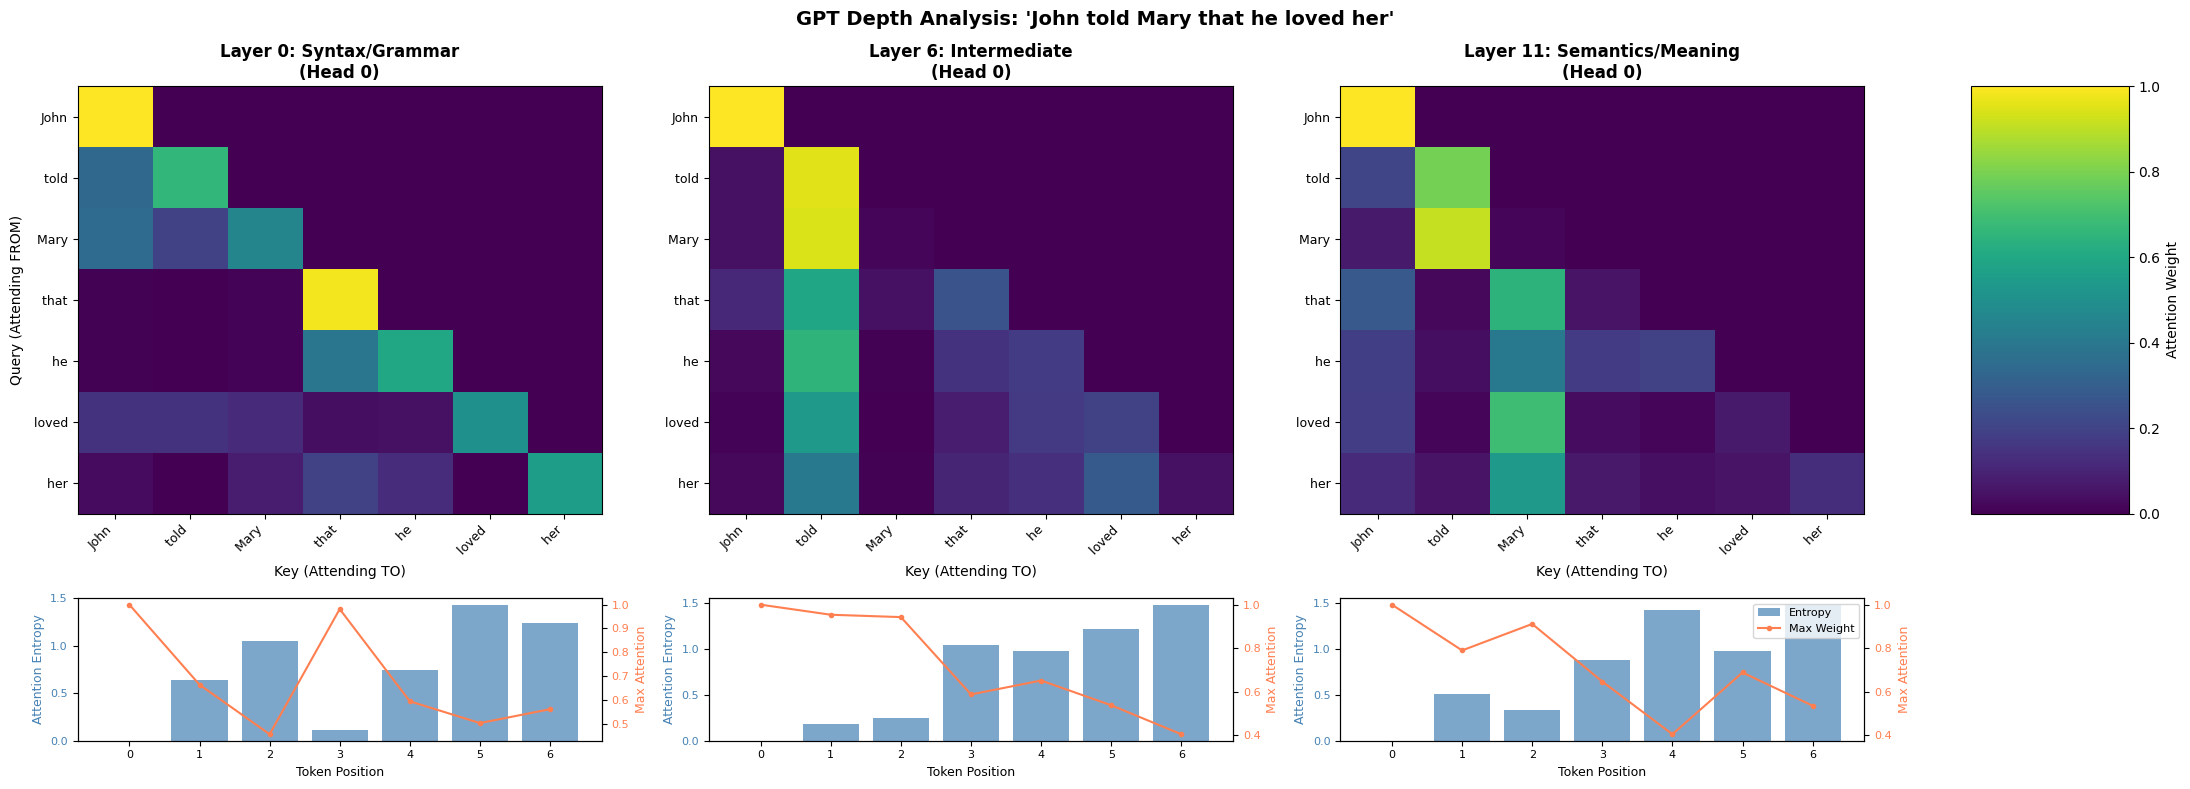


ATTENTION ANALYSIS FOR HEAD 0

Layer 0:
  Mean attention:     0.1429
  Max attention:      1.0000
  Attention entropy:  0.7443
  Top 3 attention pairs:
    'John' → 'John': 1.0000
    ' that' → ' that': 0.9817
    ' told' → ' told': 0.6637

Layer 6:
  Mean attention:     0.1429
  Max attention:      1.0000
  Attention entropy:  0.7381
  Top 3 attention pairs:
    'John' → 'John': 1.0000
    ' told' → ' told': 0.9539
    ' Mary' → ' told': 0.9430

Layer 11:
  Mean attention:     0.1429
  Max attention:      1.0000
  Attention entropy:  0.8026
  Top 3 attention pairs:
    'John' → 'John': 1.0000
    ' Mary' → ' told': 0.9114
    ' told' → ' told': 0.7897


In [ ]:
# ============================================
# FULL GPT MODEL ANALYSIS WORKFLOW
# ============================================

# Choose your test sentence
text = "John told Mary that he loved her"

print("🔍 STARTING COMPREHENSIVE ANALYSIS...")
print(f"Text: '{text}'")
print("="*80)

# 1. Basic depth scan (3 layers)
print("\n📊 1/6: Running depth scan...")
visualize_depth_scan(model, text, head_idx=0, show_stats=True)


📊 2/6: Analyzing all heads in Layer 0...


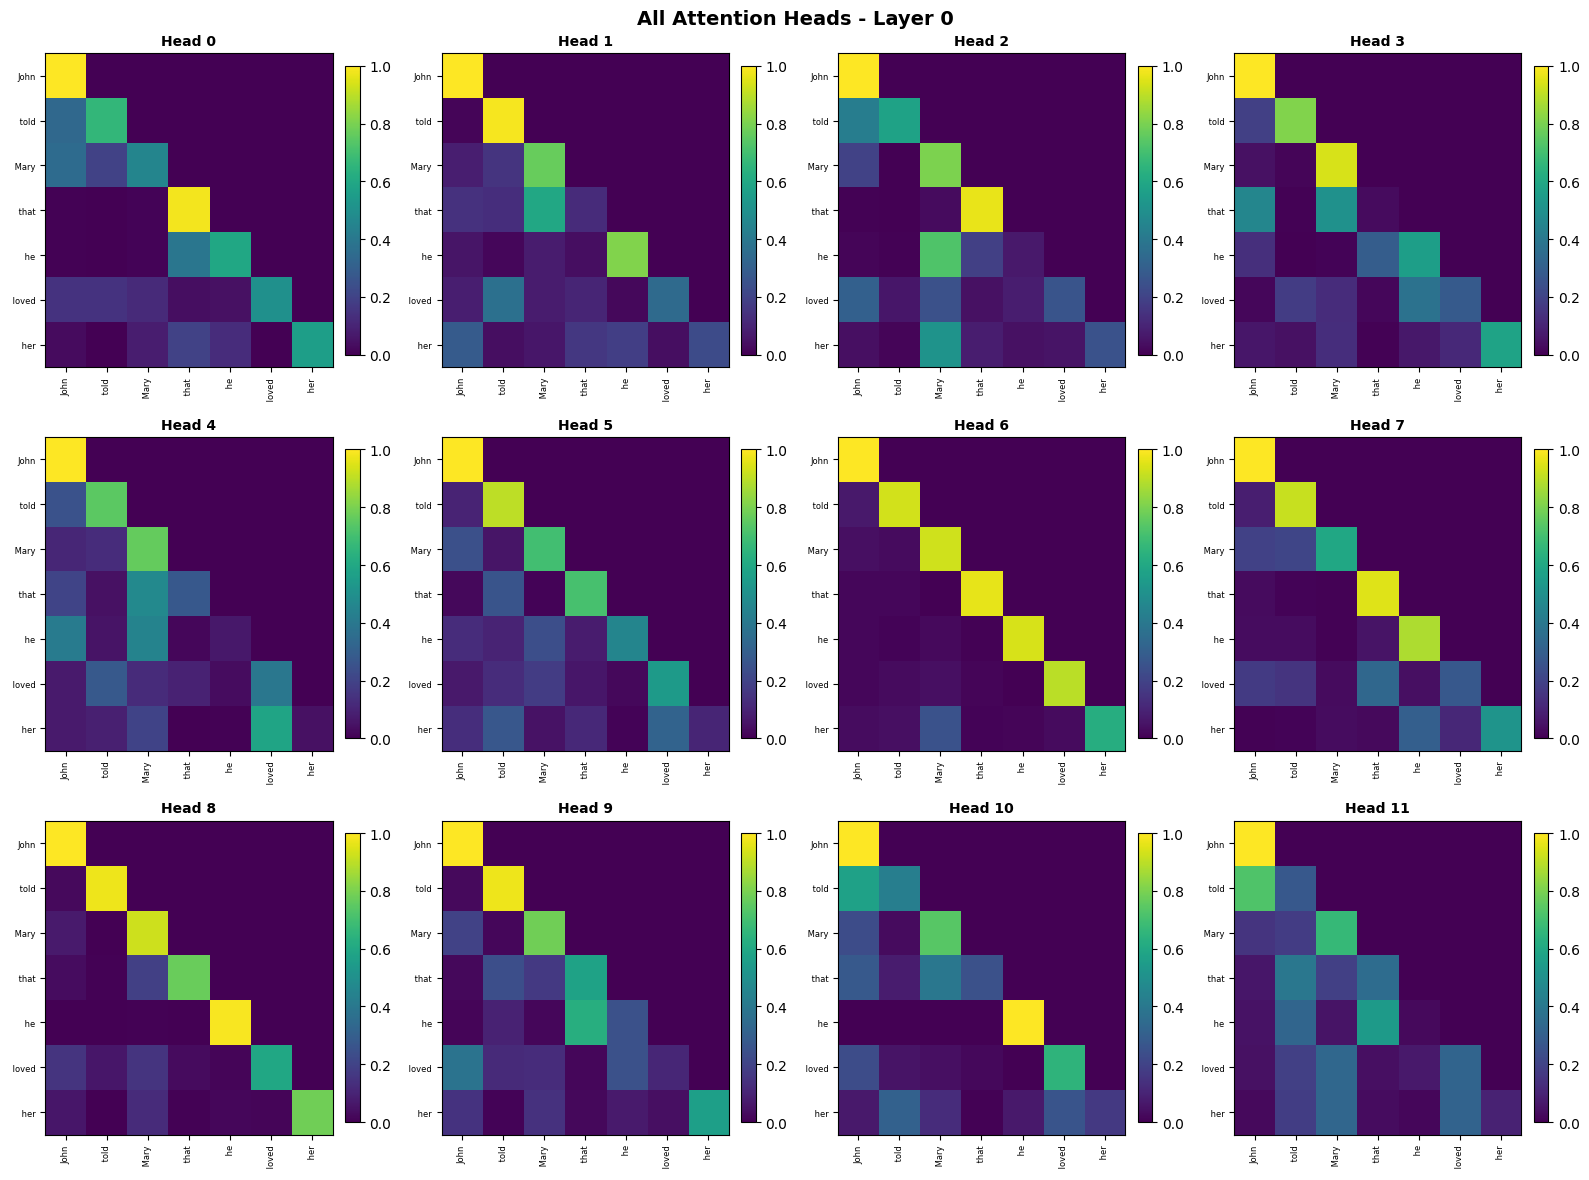

In [ ]:
# 2. Compare all heads in first layer
print("\n📊 2/6: Analyzing all heads in Layer 0...")
compare_all_heads(model, text, layer=0)


📊 3/6: Analyzing all heads in Layer 11...


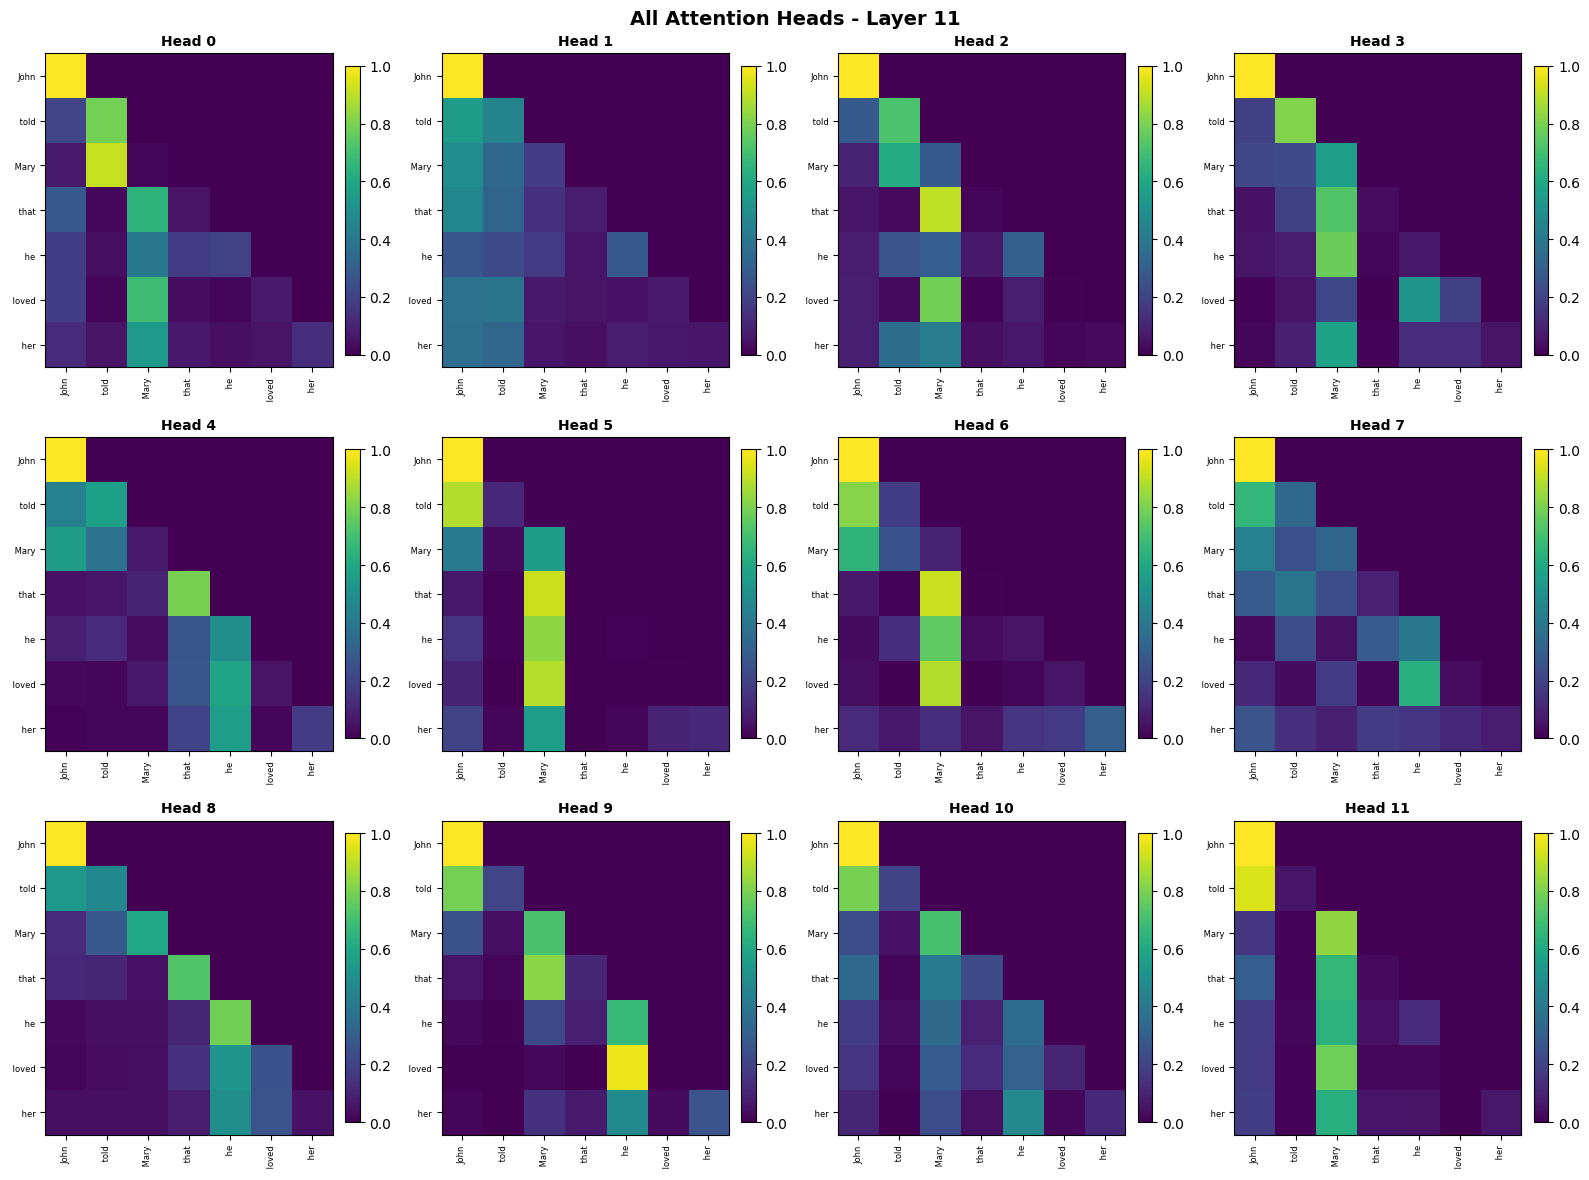

In [ ]:
# 3. Compare all heads in last layer
print("\n📊 3/6: Analyzing all heads in Layer 11...")
compare_all_heads(model, text, layer=11)


📊 4/6: Tracking attention flow...


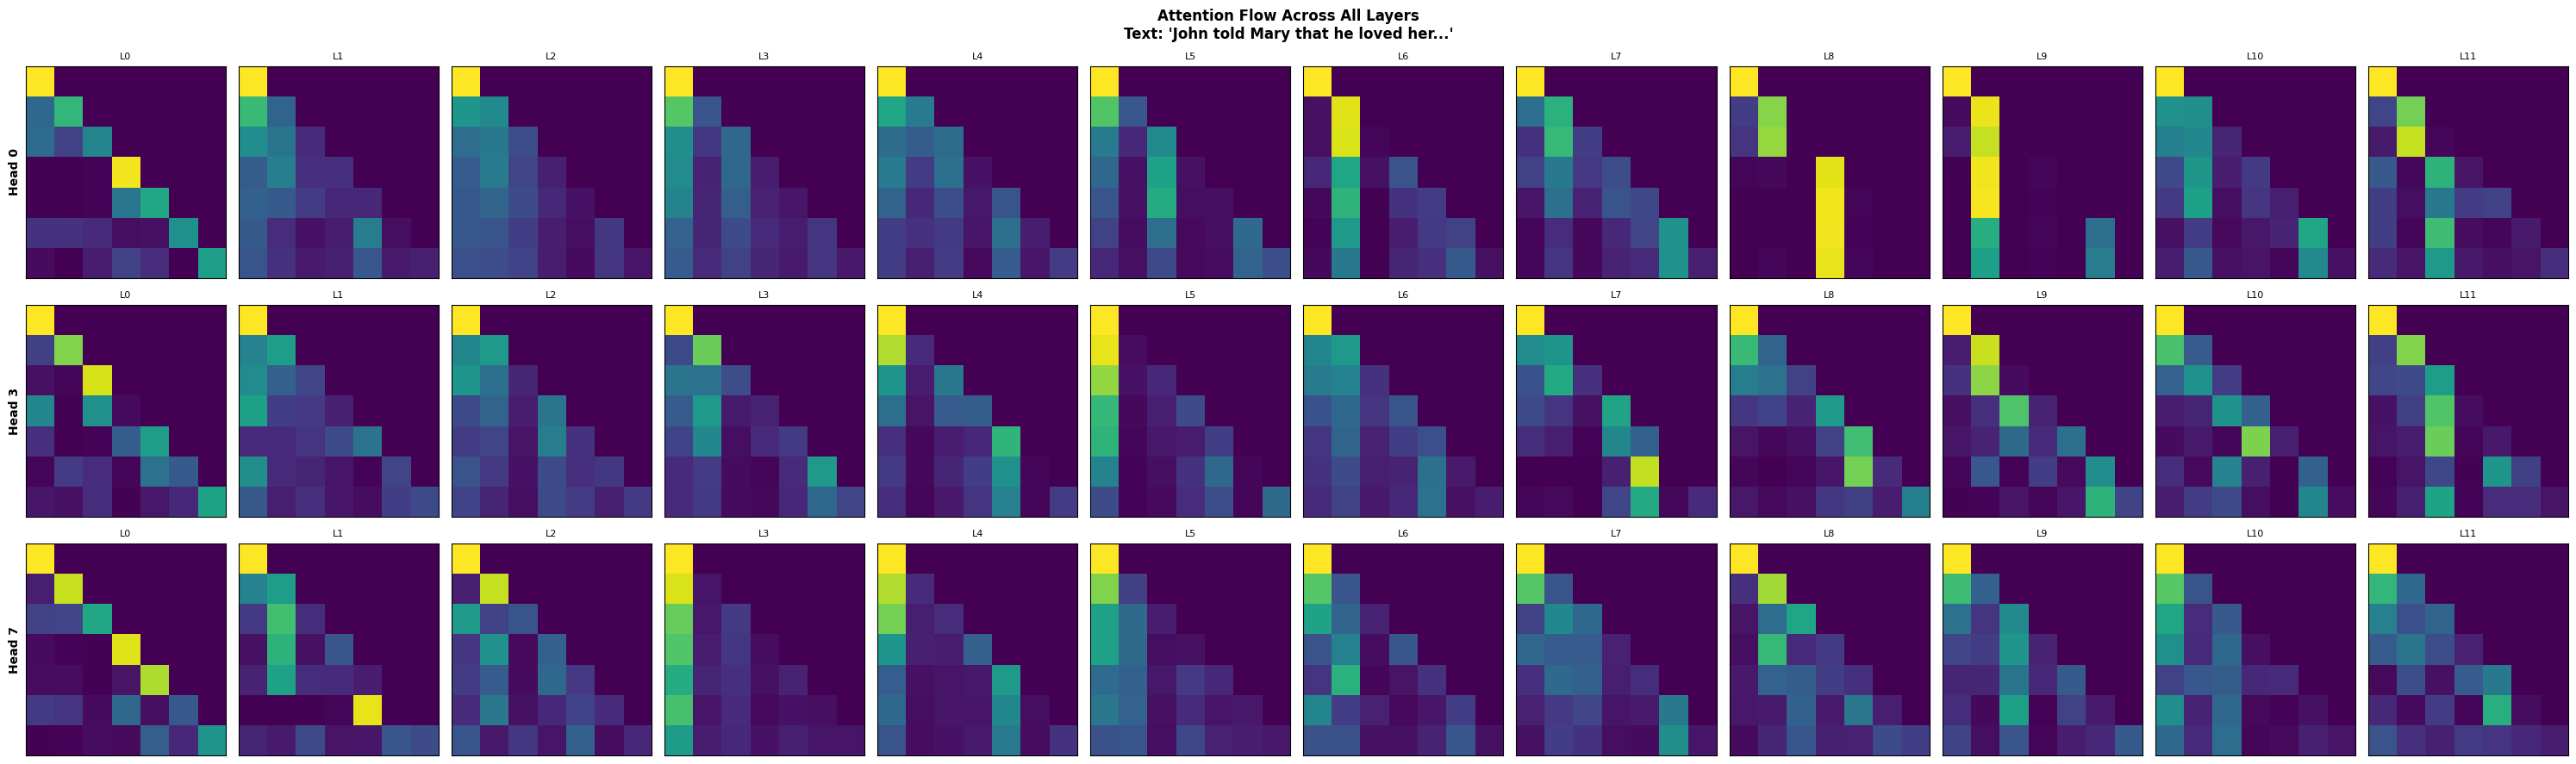

In [ ]:
# 4. Track attention flow
print("\n📊 4/6: Tracking attention flow...")
attention_flow_analysis(model, text, heads_to_track=[0, 3, 7])


📊 5/6: Analyzing entropy curve...


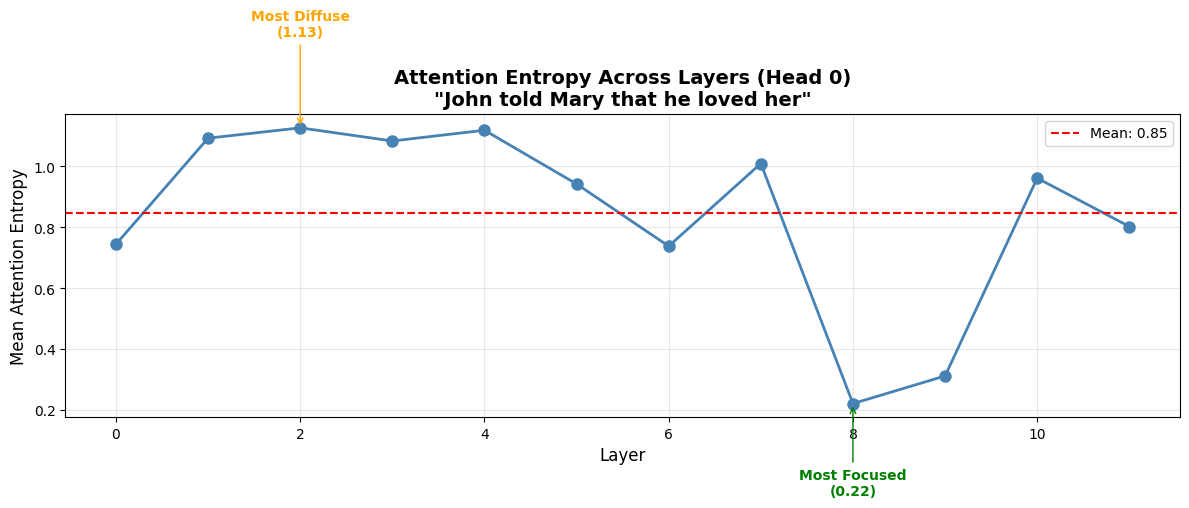


ENTROPY ANALYSIS
Mean entropy: 0.846
Std entropy:  0.291
Most focused layer:  8 (entropy: 0.222)
Most diffuse layer:  2 (entropy: 1.126)


In [ ]:
# 5. Entropy analysis
print("\n📊 5/6: Analyzing entropy curve...")
attention_entropy_curve(model, text, head_idx=0)


📊 6/6: Analyzing attention distances...


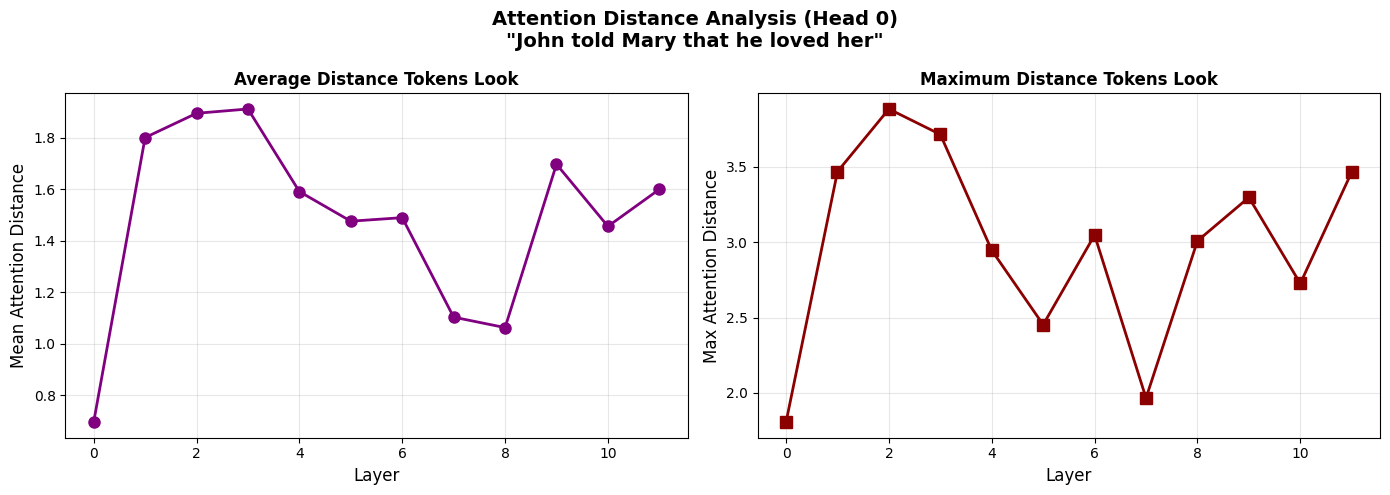


DISTANCE ANALYSIS
Early layers (0-3) mean distance:  1.58
Late layers (8-11) mean distance:   1.45
Trend: Long-range attention increases


In [ ]:
# 6. Distance analysis
print("\n📊 6/6: Analyzing attention distances...")
attention_distance_analysis(model, text, head_idx=0)

In [ ]:
# 7. Full specialization report
print("\n📊 BONUS: Generating head specialization report...")
head_specialization_report(model, text)

print("\n✅ ANALYSIS COMPLETE!")


📊 BONUS: Generating head specialization report...

HEAD SPECIALIZATION REPORT
Text: 'John told Mary that he loved her'


────────────────────────────────────────────────────────────────────────────────
LAYER 0
────────────────────────────────────────────────────────────────────────────────

  Head 0: Local/Syntactic
    Entropy:  0.744 | Locality: 1.252 | Max Attention: 1.000

  Head 1: Local/Syntactic
    Entropy:  0.826 | Locality: 1.141 | Max Attention: 1.000

  Head 2: Local/Syntactic
    Entropy:  0.731 | Locality: 1.142 | Max Attention: 1.000

  Head 3: Local/Syntactic
    Entropy:  0.767 | Locality: 1.168 | Max Attention: 1.000

  Head 4: Local/Syntactic
    Entropy:  0.901 | Locality: 1.097 | Max Attention: 1.000

  Head 5: Local/Syntactic
    Entropy:  0.887 | Locality: 1.162 | Max Attention: 1.000

  Head 6: Local/Syntactic
    Entropy:  0.372 | Locality: 1.306 | Max Attention: 1.000

  Head 7: Local/Syntactic
    Entropy:  0.681 | Locality: 1.296 | Max Attention: 1.000

  H